# Metodologia do Artigo da MMPs

### Objetivo:
O objetivo do artigo é criar um modelo baseado em técnicas de Machine Learning que possa predizer sequências de metaloproteinases com grau de confiança alto. 

Este arquivo descreve os passos da metodologia adotada no trabalho e servirá de base para a seção de metodologia do artigo que será escrito.

### Etapas não disponibilizadas nesse notebook:
Abaixo estão descritas as etapas para a consecução do objetivo:

* Download de sequências de MMPs da base Uniprot (formato FASTA)
* Download de sequências do proteoma humano da base Uniprot (formato FASTA)
* Remoção, através de blast, das sequências de MMPs no proteoma humano


### Preparação das bases
Esta etapa tem por finalidade transformar os arquivos de sequência em formato FASTA em uma matriz numérica que possa ser utilizada pelos modelos de ML.

Para isso, foi elaborado um script em python onde cada conjunto de 4 colunas representa um aminoácido presente na cadeia da sequência com as seguintes informações: massa molecular, hidrofobicidade, volume da cadeia lateral e propriedades eletrônicas. Cada uma dessas colunas foi ponderada pela frequência desse aminoáciso na cadeia da sequência.

A massa molecular de cada aminoácido foi obtida em [PubChem](https://pubchem.ncbi.nlm.nih.gov/).

As demais informações foram retiradas [deste artigo](../Artigos/Import_Determinants_of_Organelle-Specific_and_Dual.pdf) e são denominadas ZClass.

#### Subetapas que não estão disponibilizadas nesse notebook:
Após o download das sequências, precisa ser feito:

* Rodar um programa para verificar as estatísticas de cada arquivo multifasta (menor, maior, média e mediana do tamanho das sequências)
* Definir um tamanho que leve em consideração a média ou a mediana +/- um desvio padrão determinado
* Gerar um novo arquivo fasta apenas com as sequências de tamanhos previamente definido na subetapa anterior.

#### Rodando o script para a base de MMP de mamíferos

In [91]:
## O primeiro parametro eh o arquivo mutifasta. O segundo parametro eh um numero que representa a classe (o tipo de MMP) a ser convertida
!python ../Scripts/sequence2matrix_2.py ../Data/all_mmps.fasta 0 > ./mmps.csv

#### Rodando o script para a base de MMP de bactérias

In [92]:
!python ../Scripts/sequence2matrix_2.py ../Data/no_mmps_homo.fasta 1 > ./no_mmps.csv

#### Concatenando os arquivos CSV

In [93]:
cat mmps.csv no_mmps.csv > all.csv

### Rodando o modelo KNN

In [5]:
## Instalando bibliotecas de ML do python 
!pip3 install scikit-learn==0.23.1

In [6]:
## Importando as bibliotecas necessarias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import preprocessing
%matplotlib inline
from sklearn.metrics import classification_report, confusion_matrix
import itertools
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier  
import joblib


In [94]:
## Carregando os dados da matriz gerada no passo anterior
df = pd.read_csv('all.csv', header=None)
classCol = df.shape[1]-1     # Ultima coluna. Coluna com a classificacao da MMP
df.head()


,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,7.019223,0.208510,-0.501173,0.028051,14.118859,0.011094,-0.274168,0.014263,10.809572,-0.345293,...,0.027956,8.015531,0.219208,0.068051,0.142124,12.648241,0.097686,-0.221918,-0.148653,0
1,22.847391,0.678696,-1.631304,0.091304,42.608261,0.033478,-0.827391,0.043043,34.693514,-1.108225,...,0.109565,24.594565,0.672609,0.208804,0.436087,39.706667,0.306667,-0.696667,-0.466667,0
2,20.417812,0.606524,-1.457832,0.081595,34.251370,0.026912,-0.665112,0.034601,26.019407,-0.831145,...,0.108221,19.597546,0.535951,0.166380,0.347485,38.245072,0.295378,-0.671022,-0.449489,0
3,37.093412,1.101882,-2.648471,0.148235,61.314882,0.048176,-1.190647,0.061941,47.452676,-1.515794,...,0.177882,39.147059,1.070588,0.332353,0.694118,64.815294,0.500588,-1.137206,-0.761765,0
4,40.568131,1.205101,-2.896566,0.162121,62.318005,0.048965,-1.210126,0.062955,51.673030,-1.650606,...,0.176061,43.022222,1.176566,0.365253,0.762828,62.568081,0.483232,-1.097778,-0.735354,0


In [95]:
## Quantidade de registros lidos de cada tipo de MMP
mmps = pd.value_counts(df[classCol]) [0]
no_mmps = pd.value_counts(df[classCol]) [1]

tam = len(df)

print('MMPs: ',mmps)
print('No MMPs: ',no_mmps)


MMPs:  1223
No MMPs:  20525


In [99]:
## Separa a matriz original em duas matrizes: 
##      - matriz X contendo todas as colunas, exceto a ultima coluna. Conhecida como variaveis independentes
##      - matriz Y contendo a ultima coluna (coluna com a classificacao das MMPs). Conhecida como variavel dependente
#X = df.drop(classCol, axis=1).drop(0, axis=1).values
feature_df = df.iloc[:,0:80]
X = np.asarray(feature_df)
X[0:1]

array([[ 7.02e+00,  2.09e-01, -5.01e-01,  2.81e-02,  1.41e+01,  1.11e-02,
        -2.74e-01,  1.43e-02,  1.08e+01, -3.45e-01, -8.49e-02, -8.08e-02,
         1.66e+00, -2.76e-02, -3.00e-03, -4.55e-03,  7.59e+00, -2.26e-01,
         5.97e-02,  2.07e-02,  1.94e+00, -4.52e-02,  3.47e-02,  8.08e-03,
         2.78e+00,  5.40e-02,  2.68e-02, -5.97e-02,  4.40e+00,  6.59e-02,
         1.60e-02, -3.43e-02,  3.50e+00,  7.32e-02,  9.27e-04, -1.66e-03,
         7.33e+00,  1.37e-01, -1.14e-01,  3.97e-02,  6.39e+00, -6.77e-02,
         4.88e-02,  1.24e-01,  7.61e+00, -1.75e-01, -1.64e-01, -8.38e-02,
         6.03e+00, -2.04e-01, -7.72e-02, -4.73e-02,  0.00e+00,  0.00e+00,
        -0.00e+00,  0.00e+00,  7.18e+00, -5.51e-02,  9.19e-02,  3.96e-04,
         1.97e+00,  3.06e-02,  2.21e-02,  1.41e-02,  6.63e+00,  1.10e-01,
         9.58e-02, -1.31e-01,  4.40e+00,  1.07e-01,  4.83e-02,  2.80e-02,
         8.02e+00,  2.19e-01,  6.81e-02,  1.42e-01,  1.26e+01,  9.77e-02,
        -2.22e-01, -1.49e-01]])

In [97]:
y = df[classCol].values
y[0:5]

array([0, 0, 0, 0, 0])

In [98]:
## Normalizando os dados da matriz X
#X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
#normalize=True
#X[0:1]

array([[-0.45, -0.45,  0.45, -0.45, -0.45, -0.45,  0.45, -0.45, -0.45,
         0.45,  0.45,  0.45, -0.45,  0.45,  0.45,  0.45, -0.45,  0.45,
        -0.45, -0.45, -0.45,  0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
         0.45, -0.45, -0.45, -0.45,  0.45, -0.45, -0.45, -0.45,  0.45,
        -0.45, -0.45,  0.45, -0.45, -0.45,  0.45, -0.45, -0.45, -0.45,
         0.45,  0.45,  0.45, -0.45,  0.45,  0.45,  0.45, -0.45, -0.45,
         0.45, -0.45, -0.45,  0.45, -0.45, -0.45, -0.45, -0.45, -0.45,
        -0.45, -0.45, -0.45, -0.45,  0.45, -0.45, -0.45, -0.45, -0.45,
        -0.45, -0.45, -0.45, -0.45, -0.45, -0.45,  0.45,  0.45]])

In [100]:
## Dividindo as matrizes X e Y em dois subconjuntos: (1) treinamento do modelo com 80% dos dados e (2) teste do modelo com 20% dos dados
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (17398, 80) (17398,)
Test set: (4350, 80) (4350,)


#### Classificação pelo KNN
Nesse tipo de modelo, é necessário escolher o melhor K que se ajusta aos nossos dados. 'K' é o parâmetro que define para quantos melhores vizinhos o algoritmo deve "olhar" para determinar a classe. 

The best accuracy was with 0.9997701149425288 with k= 9


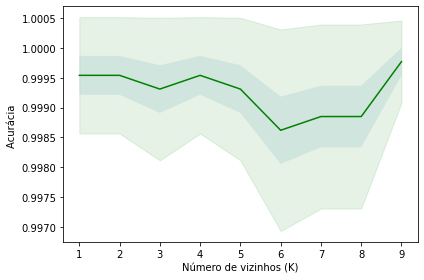

In [101]:
## Classificacao por KNN


## Aqui fazemos uma varredura de K iniciando em 1 ate 10 para identificarmos o melhor K
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

for n in range(1,Ks):
    
    #Train Model and Predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)

    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

## Plotamos o resultado
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.fill_between(range(1,Ks),mean_acc - 3 * std_acc,mean_acc + 3 * std_acc, alpha=0.10,color="green")
#plt.legend(('Acurácia ', '+/- 1xstd','+/- 3xstd'), loc='lower right')
plt.ylabel('Acurácia ')
plt.xlabel('Número de vizinhos (K)')
plt.tight_layout()
#plt.show()
#plt.savefig("/tmp/accuracy-no-legend.png",dpi=1200)

## Imprime o melhor K
print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

Matriz Confusa: 
[[ 265    1]
 [   0 4084]] 

Relatório de classificação: 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00      4084

    accuracy                           1.00      4350
   macro avg       1.00      1.00      1.00      4350
weighted avg       1.00      1.00      1.00      4350

Acurácia do modelo:  0.9997701149425288
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       266
           1       1.00      1.00      1.00      4084

    accuracy                           1.00      4350
   macro avg       1.00      1.00      1.00      4350
weighted avg       1.00      1.00      1.00      4350

Confusion matrix, without normalization
[[ 265    1]
 [   0 4084]]


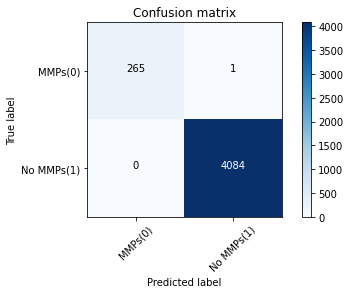

In [102]:
## Treinando com o melhor K e desenhando a matriz confusao
# Treinando o modelo KNN com o melhor parâmetro para K

#classifier = KNeighborsClassifier(n_neighbors= mean_acc.argmax()+1)
classifier = KNeighborsClassifier(n_neighbors = 9)
classifier.fit(X_train, y_train)  

# Aplicando os valores de teste novamente
y_pred = classifier.predict(X_test) 

# Importando métricas para validação do modelo

# Imprimindo a matriz confusa
print("Matriz Confusa: ")
print(confusion_matrix(y_test, y_pred), "\n")  

# Imprimindo o relatório de classificação
print("Relatório de classificação: \n", classification_report(y_test, y_pred))  


# Imprimindo o quão acurado foi o modelo
print('Acurácia do modelo: ' , accuracy_score(y_test, y_pred))


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig("/tmp/confusion.png", dpi=300)
    plt.show()

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, y_pred))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['MMPs(0)','No MMPs(1)'],normalize=False,  title='Confusion matrix')


In [103]:
## Salvando o modelo gerado
joblib.dump(classifier, "classifier_knn.model")

['classifier_knn.model']

In [47]:
# Recuperando
classifier = joblib.load('classifier_knn.model')

### SVM (Support Vector Machines)

In [2]:
## Carregando os dados da matriz 
seqs_df = pd.read_csv("all.csv", header=None)
seqs_df.head()

,0,1,2,3,4,5,6,7,8,9,...,71,72,73,74,75,76,77,78,79,80
0,4429.13,131.57,-316.24,17.7,8909.00,7.00,-173.00,9.00,6820.84,-217.88,...,17.64,5057.8,138.32,42.94,89.68,7981.04,61.64,-140.03,-93.8,0
1,6305.88,187.32,-450.24,25.2,11759.88,9.24,-228.36,11.88,9575.41,-305.87,...,30.24,6788.1,185.64,57.63,120.36,10959.04,84.64,-192.28,-128.8,0
2,9984.31,296.59,-712.88,39.9,16748.92,13.16,-325.24,16.92,12723.49,-406.43,...,52.92,9583.2,262.08,81.36,169.92,18701.84,144.44,-328.13,-219.8,0
3,12611.76,374.64,-900.48,50.4,20847.06,16.38,-404.82,21.06,16133.91,-515.37,...,60.48,13310.0,364.00,113.00,236.00,22037.20,170.20,-386.65,-259.0,0
4,16064.98,477.22,-1147.04,64.2,24677.93,19.39,-479.21,24.93,20462.52,-653.64,...,69.72,17036.8,465.92,144.64,302.08,24776.96,191.36,-434.72,-291.2,0


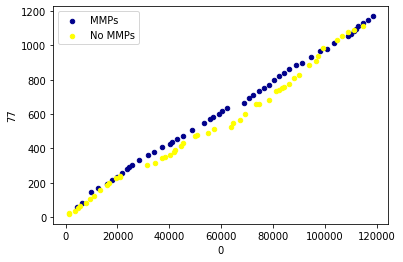

In [3]:
## Plotando o comportamento de uma amostra dos dados 
classCol = seqs_df.shape[1]-1

ax = seqs_df[seqs_df[classCol] == 0][0:50].plot(kind='scatter', x=0, y=77, color='DarkBlue', label='MMPs');
seqs_df[seqs_df[classCol] == 1][0:50].plot(kind='scatter', x=0, y=77, color='Yellow', label='No MMPs', ax=ax);
plt.show()

In [4]:
## Separando as colunas X e Y
feature_df = seqs_df.iloc[:,0:80]
X = np.asarray(feature_df)
X[0:1]


array([[ 4.42913e+03,  1.31570e+02, -3.16240e+02,  1.77000e+01,
         8.90900e+03,  7.00000e+00, -1.73000e+02,  9.00000e+00,
         6.82084e+03, -2.17880e+02, -5.35600e+01, -5.09600e+01,
         1.04503e+03, -1.74300e+01, -1.89000e+00, -2.87000e+00,
         4.79051e+03, -1.42680e+02,  3.77000e+01,  1.30500e+01,
         1.22532e+03, -2.85000e+01,  2.19000e+01,  5.10000e+00,
         1.75428e+03,  3.40800e+01,  1.69200e+01, -3.76800e+01,
         2.77666e+03,  4.16100e+01,  1.00700e+01, -2.16600e+01,
         2.20695e+03,  4.62000e+01,  5.85000e-01, -1.05000e+00,
         4.62396e+03,  8.62400e+01, -7.17200e+01,  2.50800e+01,
         4.02955e+03, -4.27000e+01,  3.08000e+01,  7.80500e+01,
         4.80315e+03, -1.10290e+02, -1.03730e+02, -5.28900e+01,
         3.80393e+03, -1.28760e+02, -4.87200e+01, -2.98700e+01,
         0.00000e+00,  0.00000e+00, -0.00000e+00,  0.00000e+00,
         4.52975e+03, -3.47500e+01,  5.80000e+01,  2.50000e-01,
         1.24088e+03,  1.92800e+01,  1.3

In [5]:
y = np.asarray(seqs_df.iloc[:,80])
y [0:5]

array([0, 0, 0, 0, 0])

In [8]:
## Dividindo a base em treinamento (80%) e teste (20%)
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (17398, 80) (17398,)
Test set: (4350, 80) (4350,)


#### Modeling (SVM with Scikit-learn)
The SVM algorithm offers a choice of kernel functions for performing its processing. Basically, mapping data into a higher dimensional space is called kernelling. The mathematical function used for the transformation is known as the kernel function, and can be of different types, such as:

```
1.Linear
2.Polynomial
3.Radial basis function (RBF)
4.Sigmoid
```

Each of these functions has its characteristics, its pros and cons, and its equation, but as there's no easy way of knowing which function performs best with any given dataset, we usually choose different functions in turn and compare the results. Let's just use the default, RBF (Radial Basis Function) for this lab.


In [12]:
## Rodando com o algoritmo escolhido
from sklearn import svm
clf = svm.SVC(kernel='rbf')
clf.fit(X_train, y_train) 
yhat = clf.predict(X_test)
yhat [0:5]

array([1, 1, 1, 0, 1])

              precision    recall  f1-score   support

           0       0.69      0.95      0.80       266
           1       1.00      0.97      0.98      4084

    accuracy                           0.97      4350
   macro avg       0.84      0.96      0.89      4350
weighted avg       0.98      0.97      0.97      4350

Confusion matrix, without normalization
[[ 253   13]
 [ 115 3969]]


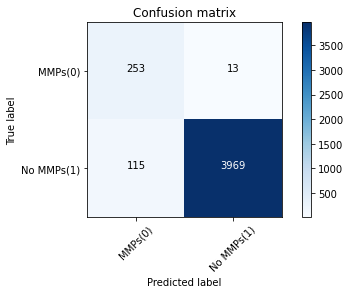

In [13]:
## Gerando a matriz confusao
from sklearn.metrics import classification_report, confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['MMPs(0)','No MMPs(1)'],normalize= False,  title='Confusion matrix')

In [14]:
## Salvando o modelo gerado
import joblib
joblib.dump(clf, "classifier_svm.model")

['classifier_svm.model']

In [15]:
# Recuperando
classifier = joblib.load('classifier_svm.model')

### Aplicando no mundo real

In [104]:
## Convertendo o arquivo em matriz
!python ../Scripts/sequence2matrix_2.py ../Data/real.fasta 0 > ./proteoma_humano.csv

In [105]:
real = pd.read_csv("proteoma_humano.csv", header=None)
real.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,7.019223,0.208510,-0.501173,0.028051,14.118859,0.011094,-0.274168,0.014263,10.809572,-0.345293,...,0.048257,0.027956,8.015531,0.219208,0.068051,0.142124,12.648241,0.097686,-0.221918,-0.148653
1,22.847391,0.678696,-1.631304,0.091304,42.608261,0.033478,-0.827391,0.043043,34.693514,-1.108225,...,0.189130,0.109565,24.594565,0.672609,0.208804,0.436087,39.706667,0.306667,-0.696667,-0.466667
2,20.417812,0.606524,-1.457832,0.081595,34.251370,0.026912,-0.665112,0.034601,26.019407,-0.831145,...,0.186810,0.108221,19.597546,0.535951,0.166380,0.347485,38.245072,0.295378,-0.671022,-0.449489
3,37.093412,1.101882,-2.648471,0.148235,61.314882,0.048176,-1.190647,0.061941,47.452676,-1.515794,...,0.307059,0.177882,39.147059,1.070588,0.332353,0.694118,64.815294,0.500588,-1.137206,-0.761765
4,40.568131,1.205101,-2.896566,0.162121,62.318005,0.048965,-1.210126,0.062955,51.673030,-1.650606,...,0.303914,0.176061,43.022222,1.176566,0.365253,0.762828,62.568081,0.483232,-1.097778,-0.735354


In [106]:
#X_real = real.drop(0, axis=1).values
X_real = np.asarray(real)
X_real[0:1]

array([[ 7.02e+00,  2.09e-01, -5.01e-01,  2.81e-02,  1.41e+01,  1.11e-02,
        -2.74e-01,  1.43e-02,  1.08e+01, -3.45e-01, -8.49e-02, -8.08e-02,
         1.66e+00, -2.76e-02, -3.00e-03, -4.55e-03,  7.59e+00, -2.26e-01,
         5.97e-02,  2.07e-02,  1.94e+00, -4.52e-02,  3.47e-02,  8.08e-03,
         2.78e+00,  5.40e-02,  2.68e-02, -5.97e-02,  4.40e+00,  6.59e-02,
         1.60e-02, -3.43e-02,  3.50e+00,  7.32e-02,  9.27e-04, -1.66e-03,
         7.33e+00,  1.37e-01, -1.14e-01,  3.97e-02,  6.39e+00, -6.77e-02,
         4.88e-02,  1.24e-01,  7.61e+00, -1.75e-01, -1.64e-01, -8.38e-02,
         6.03e+00, -2.04e-01, -7.72e-02, -4.73e-02,  0.00e+00,  0.00e+00,
        -0.00e+00,  0.00e+00,  7.18e+00, -5.51e-02,  9.19e-02,  3.96e-04,
         1.97e+00,  3.06e-02,  2.21e-02,  1.41e-02,  6.63e+00,  1.10e-01,
         9.58e-02, -1.31e-01,  4.40e+00,  1.07e-01,  4.83e-02,  2.80e-02,
         8.02e+00,  2.19e-01,  6.81e-02,  1.42e-01,  1.26e+01,  9.77e-02,
        -2.22e-01, -1.49e-01]])

In [18]:
## Normalizando os dados
#X_real = preprocessing.StandardScaler().fit(X_real).transform(X_real.astype(float))
#X_real[0:1]

array([[-1.74, -1.74,  1.74, -1.74, -1.7 , -1.7 ,  1.7 , -1.7 , -1.67,
         1.67,  1.67,  1.67, -1.69,  1.69,  1.69,  1.69, -1.83,  1.83,
        -1.83, -1.83, -1.8 ,  1.8 , -1.8 , -1.8 , -1.69, -1.69, -1.69,
         1.69, -1.68, -1.68, -1.68,  1.68, -1.66, -1.66, -1.66,  1.66,
        -1.67, -1.67,  1.67, -1.67, -1.71,  1.71, -1.71, -1.71, -1.69,
         1.69,  1.69,  1.69, -1.71,  1.71,  1.71,  1.71, -1.65, -1.65,
         1.65, -1.65, -1.81,  1.81, -1.81, -1.81, -1.71, -1.71, -1.71,
        -1.71, -1.68, -1.68, -1.68,  1.68, -1.75, -1.75, -1.75, -1.75,
        -1.78, -1.78, -1.78, -1.78, -1.71, -1.71,  1.71,  1.71]])

In [107]:
# Aplicando os valores de teste novamente
y_pred_real = classifier.predict(X_real) 
y_pred_real

array([0, 0, 0, ..., 1, 1, 1])

In [108]:
file = open('preditos.txt', 'w')
for i in y_pred_real:
    file.write(str(i))
    file.write('\n')
file.close()

# Artigo Beiji

In [109]:
# Transformando os fastas em csv
!python ../Scripts/sequence2matrix_2.py /opt/working/MMPs/Metodologia/Data/artigo_Beigi/mmps.fasta 0 > ./mmps.csv
!python ../Scripts/sequence2matrix_2.py /opt/working/MMPs/Metodologia/Data/artigo_Beigi/adams.fasta 1 > ./adams.csv
!python ../Scripts/sequence2matrix_2.py /opt/working/MMPs/Metodologia/Data/artigo_Beigi/negative.fasta 2 > ./negative.csv

In [7]:
# Recuperando o modelo saldo do KNN
classifier = joblib.load('classifier_knn.model')

In [116]:
# Lendo o csv
real = pd.read_csv("negative.csv", header=None)
real.head()

,0,1,2,3,4,5,6,7,8,9,...,70,71,72,73,74,75,76,77,78,79
0,4.628981,0.137507,-0.330509,0.018499,5.493485,0.004316,-0.106676,0.005550,14.769812,-0.471796,...,0.073861,0.042788,4.282038,0.117105,0.036354,0.075925,6.387131,0.049330,-0.112064,-0.075067
1,9.763439,0.290029,-0.697110,0.039017,11.844335,0.009306,-0.230000,0.011965,25.779075,-0.823468,...,0.171821,0.099538,12.694509,0.347168,0.107775,0.225087,12.393988,0.095723,-0.217457,-0.145665
2,9.971501,0.296210,-0.711965,0.039849,10.967883,0.008618,-0.212981,0.011080,23.939233,-0.764698,...,0.114309,0.066220,11.355184,0.310540,0.096404,0.201339,10.548423,0.081469,-0.185076,-0.123974
3,32.568831,0.967477,-2.325415,0.130154,39.199600,0.030800,-0.761200,0.039600,83.141600,-2.655815,...,0.379231,0.219692,39.315692,1.075200,0.333785,0.697108,34.453169,0.266092,-0.604492,-0.404923
4,36.256718,1.077028,-2.588731,0.144892,45.786192,0.035975,-0.889102,0.046254,98.275975,-3.139257,...,0.457895,0.265263,46.976471,1.284706,0.398824,0.832941,37.616842,0.290526,-0.660000,-0.442105


In [117]:
# Separando as variaveis independentes
X_real = np.asarray(real)
X_real[0:1]

array([[ 4.63e+00,  1.38e-01, -3.31e-01,  1.85e-02,  5.49e+00,  4.32e-03,
        -1.07e-01,  5.55e-03,  1.48e+01, -4.72e-01, -1.16e-01, -1.10e-01,
         1.60e+00, -2.67e-02, -2.90e-03, -4.40e-03,  7.09e+00, -2.11e-01,
         5.58e-02,  1.93e-02,  4.38e+00, -1.02e-01,  7.83e-02,  1.82e-02,
         1.02e+01,  1.98e-01,  9.83e-02, -2.19e-01,  4.70e+00,  7.05e-02,
         1.71e-02, -3.67e-02,  9.86e+00,  2.06e-01,  2.61e-03, -4.69e-03,
         8.17e+00,  1.52e-01, -1.27e-01,  4.43e-02,  5.56e+00, -5.89e-02,
         4.25e-02,  1.08e-01,  8.17e+00, -1.88e-01, -1.76e-01, -8.99e-02,
         8.09e+00, -2.74e-01, -1.04e-01, -6.35e-02,  1.62e+00,  9.52e-03,
        -1.30e-02,  5.54e-02,  8.26e+00, -6.34e-02,  1.06e-01,  4.56e-04,
         3.33e+00,  5.17e-02,  3.73e-02,  2.38e-02,  7.94e+00,  1.31e-01,
         1.15e-01, -1.57e-01,  6.73e+00,  1.64e-01,  7.39e-02,  4.28e-02,
         4.28e+00,  1.17e-01,  3.64e-02,  7.59e-02,  6.39e+00,  4.93e-02,
        -1.12e-01, -7.51e-02]])

In [87]:
## Normalizando os dados
#X_real = preprocessing.StandardScaler().fit(X_real).transform(X_real.astype(float))
#X_real[0:1]

array([[-1.68, -1.68,  1.68, -1.68, -1.64, -1.64,  1.64, -1.64, -1.65,
         1.65,  1.65,  1.65, -1.63,  1.63,  1.63,  1.63, -1.68,  1.68,
        -1.68, -1.68, -1.6 ,  1.6 , -1.6 , -1.6 , -1.66, -1.66, -1.66,
         1.66, -1.65, -1.65, -1.65,  1.65, -1.64, -1.64, -1.64,  1.64,
        -1.6 , -1.6 ,  1.6 , -1.6 , -1.63,  1.63, -1.63, -1.63, -1.66,
         1.66,  1.66,  1.66, -1.66,  1.66,  1.66,  1.66, -1.59, -1.59,
         1.59, -1.59, -1.65,  1.65, -1.65, -1.65, -1.63, -1.63, -1.63,
        -1.63, -1.62, -1.62, -1.62,  1.62, -1.67, -1.67, -1.67, -1.67,
        -1.65, -1.65, -1.65, -1.65, -1.6 , -1.6 ,  1.6 ,  1.6 ]])

In [118]:
# Aplicando os valores de teste novamente
y_pred_real = classifier.predict(X_real) 
y_pred_real

array([0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,